<a href="https://colab.research.google.com/github/thesimaranjaira/Show-and-Tell/blob/main/imagecaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [275]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from tqdm import tqdm
import pandas as pd
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Input
from keras.layers  import concatenate
from keras.layers.merge import add
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
import nltk
from nltk.translate.bleu_score import corpus_bleu

In [10]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [13]:
token = '/content/gdrive/My Drive/dataset/Flickr8k_text/Flickr8k.token.txt'
captions = open(token, 'r').read().strip().split('\n')

In [14]:
d = {}
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [15]:
d['2405599120_ec5f32af6f.jpg']

['A baby is sitting on the floor surrounded by diapers and basket .',
 'A baby on a floor with an overturned basket and articles on the floor .',
 'A baby plays near an overturned basket of diapers .',
 'A toddler sits with diapers spread around the floor .',
 'a young baby sitting in the middle of the floor surrounded by clean diapers']

In [20]:
images = '/content/gdrive/My Drive/dataset/Flicker8k_Dataset/'


In [24]:
img = glob.glob(images+'*.jpg')
img[:5]

['/content/gdrive/My Drive/dataset/Flicker8k_Dataset/386160015_d4b31df68e.jpg',
 '/content/gdrive/My Drive/dataset/Flicker8k_Dataset/387830531_e89c192b92.jpg',
 '/content/gdrive/My Drive/dataset/Flicker8k_Dataset/386655611_1329495f97.jpg',
 '/content/gdrive/My Drive/dataset/Flicker8k_Dataset/378453580_21d688748e.jpg',
 '/content/gdrive/My Drive/dataset/Flicker8k_Dataset/380034515_4fbdfa6b26.jpg']

In [26]:

train_images_file = '/content/gdrive/My Drive/dataset/Flickr8k_text/Flickr_8k.trainImages.txt'

In [27]:
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [28]:
def split_data(l):
    temp = []
    for i in img:
        if i[len(images):] in l:
            temp.append(i)
    return temp

In [29]:
train_img = split_data(train_images)
len(train_img)

6000

In [31]:
val_images_file = '/content/gdrive/My Drive/dataset/Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))

In [32]:
val_img = split_data(val_images)
len(val_img)

1000

In [33]:
test_images_file = '/content/gdrive/My Drive/dataset/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [34]:
test_img = split_data(test_images)
len(test_img)

1000

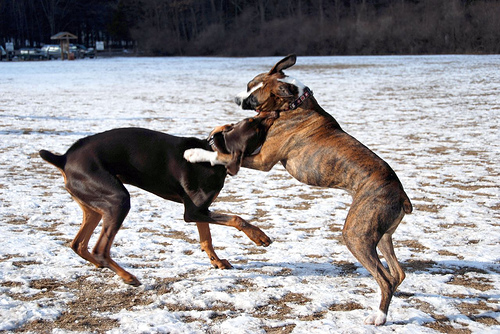

In [35]:
Image.open(train_img[0])

In [36]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [37]:

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    x = preprocess_input(x)
    return x

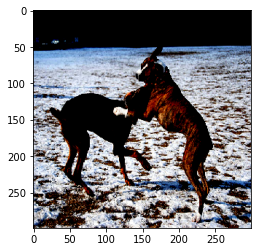

In [38]:
plt.imshow(np.squeeze(preprocess(train_img[0])))

In [39]:
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 2s 0us/step


In [40]:
from keras.models import Model

new_input = model.input
hidden_layer = model.layers[-2].output

model_new = Model(new_input, hidden_layer)

In [41]:
tryi = model_new.predict(preprocess(train_img[0]))

In [42]:
tryi.shape

(1, 2048)

In [43]:
def encode(image):
    image = preprocess(image)
    temp_enc = model_new.predict(image)
    temp_enc = np.reshape(temp_enc, temp_enc.shape[1])
    return temp_enc

In [44]:
encoding_train = {}
for img in tqdm(train_img):
    encoding_train[img[len(images):]] = encode(img)

100%|██████████| 6000/6000 [51:05<00:00,  1.96it/s]


In [64]:
with open("encoded_images_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [65]:
encoding_train = pickle.load(open('encoded_images_inceptionV3.p', 'rb'))

In [66]:
encoding_train['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [67]:
encoding_test = {}
for img in tqdm(test_img):
    encoding_test[img[len(images):]] = encode(img)

100%|██████████| 1000/1000 [08:35<00:00,  1.94it/s]


In [68]:
with open("encoded_images_test_inceptionV3.p", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [69]:
encoding_test = pickle.load(open('encoded_images_test_inceptionV3.p', 'rb'))

In [70]:
encoding_test[test_img[0][len(images):]].shape

(2048,)

In [71]:
train_d = {}
for i in train_img:
    if i[len(images):] in d:
        train_d[i] = d[i[len(images):]]

In [72]:
len(train_d)

6000

In [73]:
train_d[images+'3556792157_d09d42bef7.jpg']

['A bunch of children sitting in chairs and standing on wooden floors .',
 'A group of children sit , stand , and kneel along a wall .',
 'A group of children sitting on folding chairs and playing .',
 'a young group of children sitting in a row against the wall .',
 'The kids talking while sitting on a row of chairs along the wall .']

In [74]:
val_d = {}
for i in val_img:
    if i[len(images):] in d:
        val_d[i] = d[i[len(images):]]

In [75]:
len(val_d)

1000

In [76]:
test_d = {}
for i in test_img:
    if i[len(images):] in d:
        test_d[i] = d[i[len(images):]]

In [77]:
len(test_d)

1000

In [78]:

caps = []
for key, val in train_d.items():
    for i in val:
        caps.append('<start> ' + i + ' <end>')

In [79]:
words = [i.split() for i in caps]

In [80]:

unique = []
for i in words:
    unique.extend(i)

In [84]:
unique = list(set(unique))

In [85]:
with open("unique.p", "wb") as pickle_d:
    pickle.dump(unique, pickle_d)

In [86]:

unique = pickle.load(open('unique.p', 'rb'))

In [87]:
len(unique)

8256

In [88]:
word2idx = {val:index for index, val in enumerate(unique)}

In [89]:
word2idx['<start>']

4510

In [90]:
idx2word = {index:val for index, val in enumerate(unique)}

In [92]:

idx2word[4510]

'<start>'

In [93]:

max_len = 0
for c in caps:
    c = c.split()
    if len(c) > max_len:
        max_len = len(c)
max_len

40

In [95]:

len(unique), max_len

(8256, 40)

In [96]:
vocab_size = len(unique)

In [97]:

vocab_size

8256

In [98]:
f = open('flickr8k_training_dataset.txt', 'w')
f.write("image_id\tcaptions\n")


18

In [99]:
for key, val in train_d.items():
    for i in val:
        f.write(key[len(images):] + "\t" + "<start> " + i +" <end>" + "\n")

f.close()

In [103]:
df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')

In [104]:
len(df)

30000

In [112]:
c = [i for i in df['captions']]
len(c)

30000

In [113]:
imgs = [i for i in df['image_id']]

In [114]:
a = c[-1]
a, imgs[-1]

('<start> Two horses pulling a sled steered by a smiling blond woman . <end>',
 '109202801_c6381eef15.jpg')

In [115]:
for i in a.split():
    print (i, "=>", word2idx[i])

<start> => 4510
Two => 3194
horses => 2788
pulling => 427
a => 4233
sled => 7307
steered => 722
by => 1660
a => 4233
smiling => 3655
blond => 3756
woman => 2254
. => 2203
<end> => 6150


In [116]:

samples_per_epoch = 0
for ca in caps:
    samples_per_epoch += len(ca.split())-1

In [117]:
samples_per_epoch

383454

**GENERATOR**

In [119]:
def data_generator(batch_size = 32):
        partial_caps = []
        next_words = []
        images = []
        
        df = pd.read_csv('flickr8k_training_dataset.txt', delimiter='\t')
        df = df.sample(frac=1)
        iter = df.iterrows()
        c = []
        imgs = []
        for i in range(df.shape[0]):
            x = next(iter)
            c.append(x[1][1])
            imgs.append(x[1][0])


        count = 0
        while True:
            for j, text in enumerate(c):
                current_image = encoding_train[imgs[j]]
                for i in range(len(text.split())-1):
                    count+=1
                    
                    partial = [word2idx[txt] for txt in text.split()[:i+1]]
                    partial_caps.append(partial)
                    
                    # Initializing with zeros to create a one-hot encoding matrix
                    # This is what we have to predict
                    # Hence initializing it with vocab_size length
                    n = np.zeros(vocab_size)
                    # Setting the next word to 1 in the one-hot encoded matrix
                    n[word2idx[text.split()[i+1]]] = 1
                    next_words.append(n)
                    
                    images.append(current_image)

                    if count>=batch_size:
                        next_words = np.asarray(next_words)
                        images = np.asarray(images)
                        partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                        yield [[images, partial_caps], next_words]
                        partial_caps = []
                        next_words = []
                        images = []
                        count = 0


**CREATE** **MODEL**

In [183]:
embedding_size = 300

In [230]:
image_model = Sequential([
        Dense(embedding_size, input_shape=(2048,), activation='relu'),
        RepeatVector(max_len)
    ])

In [185]:
caption_model = Sequential([
        Embedding(vocab_size, embedding_size, input_length=max_len),
        LSTM(256, return_sequences=True),
        TimeDistributed(Dense(300))
    ])

In [277]:
final_model = Sequential([
        merge([image_model, caption_model], mode='concat', concat_axis=1),
        Bidirectional(LSTM(256, return_sequences=False)),
        Dense(vocab_size),
        Activation('softmax')
    ])

TypeError: ignored